## Overview of functionalities

This notebook gives an overview of the functionalities of the delft3dfmpy module.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

In [1]:
# Basis
import os
import sys
import shutil

# Add path to module, of it is not in your site-packages folder.
sys.path.append('d:/Documents/GitHub')

# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

### Read HYDAMO

In the code section below the different parts or the HyDAMO gml are added. For more info on how to import the different elements from the HyDAMO gml, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing the HyDAMO files are:
- Read the objects from the GML file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the difference to the nearest branch was too large.

A few remarks:
- The converter requires a number of features with a specfic name. If the name in the gml does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length o f10 characters, so probably a lot of column_mapping is necessary.

In [2]:
# Parse HyDAMO model within extent file
hydamo = HyDAMO(extent_file='../data/gis/selectie_pilot.shp')

# Branches
hydamo.branches.read_gml('../data/gml/hydroobject.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4

# Cross sections
hydamo.crosssections.read_gml(
    '../data/gml/dwarsprofiel.gml',
    index_col='profielcode',
    groupby_column='profielcode',
    order_column='codevolgnummer',
    column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'}
)
hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections.drop('code', inplace=True, axis=1)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)

# Culverts
hydamo.culverts.read_gml(
    '../data/gml/duikersifonhevel.gml',
    index_col='code',
    column_mapping={'vormkoker': 'vormcode'},
    clip=hydamo.clipgeo
)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
# Remove some of the culverts since they are badly schematised and do therefor
# have a negative effect on the FM computation time
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts.drop(duikers_rekentijd, inplace=True, axis=0)
hydamo.culverts.drop(duikers_gemalen, inplace=True, axis=0)

# Weirs
hydamo.weirs.read_gml('../data/gml/stuw.gml')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Laterals (imported from shapefile)
hydamo.laterals.read_shp('../data/sobekdata/Sbk_S3BR_n.shp', column_mapping={'ID        ': 'code', 'NAME      ': 'name'})
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Pumps
hydamo.gemalen.read_gml('../data/gml/gemaal.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml('../data/gml/pomp.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml('../data/gml/sturing.gml', index_col='code')

Plot the model with branches, cross sections and weirs

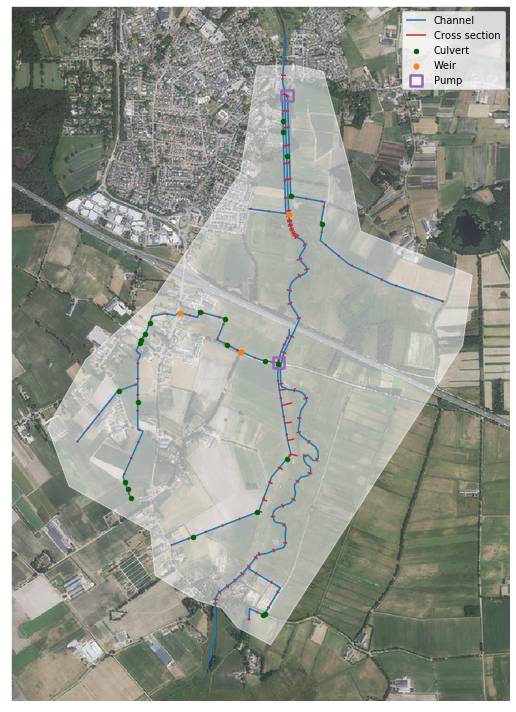

In [3]:
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread('../data/gis/achtergrond.png')
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel')
hydamo.crosssections.plot(ax=ax, color='C3', label='Cross section')
hydamo.culverts.centroid.plot(ax=ax, color='darkgreen', label='Culvert', markersize=20, zorder=10)
hydamo.weirs.centroid.plot(ax=ax, color='C1', label='Weir', markersize=25, zorder=10)
hydamo.pumps.centroid.plot(
    ax=ax, color='C4', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)

ax.legend()

fig.tight_layout()

### Convert to D-HYDRO schematisation

Convert the geometries to D-HYDRO schematisation:

Start with importing the structures (from HyDAMO in this case), since the position of the structure can be used in defining the position of the 1d nodes. 

Structures can also be added without the HyDAMO imports. One weir is added manually, but this can be done for all implemented structures.

Note that for importing the pumps three gml-files are needed. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.


In [4]:
dfmmodel = DFlowFMModel()

# Collect structures
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)

# Add a weir manually
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='riv_RS1_1810',
    chainage=950.0,
    crestlevel=8.00,
    crestwidth=7.5,
    dischargecoeff=1.0,
    latdiscoeff=1.0,
    allowedflowdir=0,
)


After this add the branches and generate a grid.

In [5]:
# Create a 1D schematisation
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=40.0, seperate_structures=True)

Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

In [6]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    dwarsprofielen=hydamo.crosssections,
    parameterised=hydamo.parametrised_profiles
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')

2 branches are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

In [7]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30)
dfmmodel.crosssections.set_default_definition(definition=default, shift=5.0)

Add 2D Mesh. The converter supports creating a rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

In [8]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

# Generate mesh within model bounds
mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(10)
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize)

# Determine the altitude from a digital elevation model
# rasterpath = '../gis/AHNdommel_clipped.tif'
# mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
mesh.altitude_constant(15.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells.

The last option is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [9]:
dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

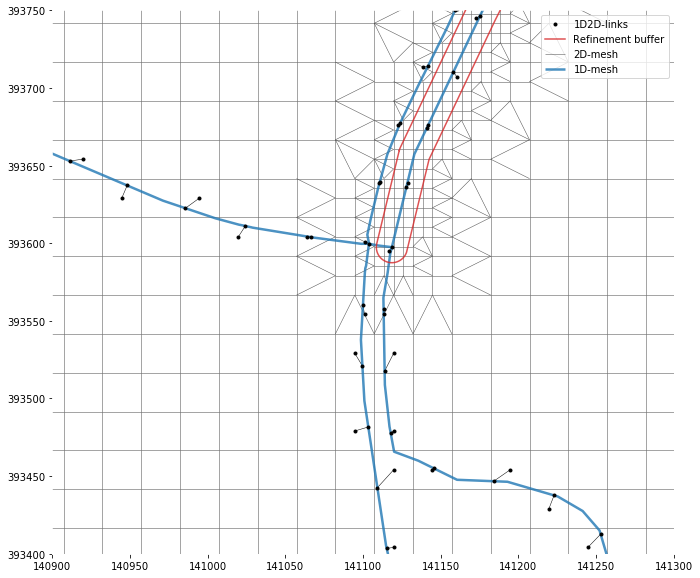

In [10]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

### Boundary conditions

Add boundary conditions to external forcings from a SOBEK time series.

In [12]:
bcs = pd.read_csv('../data/sobekdata/boundaryconditions.csv', sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)

In [13]:
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_flow_in',
    pt=(140712.056047, 391893.277878),
    bctype='discharge',
    series=bcs['Discharge']
)

dfmmodel.external_forcings.add_boundary_condition(
    name='BC_wlev_down',
    pt=(141133.788766, 395441.748424),
    bctype='waterlevel',
    series=bcs['Waterlevel']
)

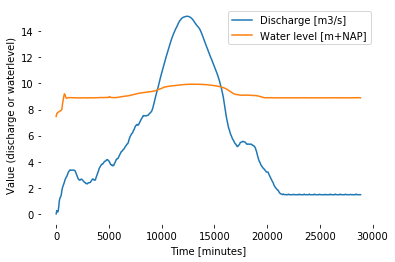

In [14]:
fig, ax = plt.subplots()

ax.plot(
    dfmmodel.external_forcings.boundaries.at['BC_flow_in', 'time'],
    dfmmodel.external_forcings.boundaries.at['BC_flow_in', 'value'],
    label='Discharge [m3/s]'
)

ax.plot(
    dfmmodel.external_forcings.boundaries.at['BC_wlev_down', 'time'],
    dfmmodel.external_forcings.boundaries.at['BC_wlev_down', 'value'],
    label='Water level [m+NAP]'
)

ax.set_ylabel('Value (discharge or waterlevel)')
ax.set_xlabel('Time [minutes]')

ax.legend();

In [15]:
# Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy

In [16]:
# Add the lateral inflows also from the SOBEK results. Note that the column names in the his-file need to match
# the id's of the imported lateral locations at the top of this notebook.
rehis = hkvsobekpy.read_his.ReadMetadata('../data/sobekdata/QLAT.HIS', hia_file='auto')
param = [p for p in rehis.GetParameters() if 'disch' in p][0]
lateral_discharge = rehis.DataFrame().loc[:, param]
lateral_discharge.drop('lat_986', inplace=True, axis=1)

dfmmodel.external_forcings.io.read_laterals(hydamo.laterals, lateral_discharge)

Add observation points from shape file

In [17]:
dfmmodel.observation_points.add_point((141150, 393700), 'ObsPt', snap_to_1d=True)

### Settings and writing

Finally, we adjust some settings and export the model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf


In [18]:
# Runtime and output settings
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] = 24.0 * 20 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# Create writer
writer = DFlowFMWriter(dfmmodel, output_dir='../testmodel', name='moergestels_broek')

# Write as model
writer.objects_to_ldb()
writer.write_all()